In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas as pd
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# pytorch relates imports
import torch
import torch.nn as nn
import torch.optim as optim

# imports from captum library
from captum.attr import IntegratedGradients, Saliency, Occlusion

# ANN construction

In [2]:
a = os.listdir()
ANN_files = []
Dataset_files = []

for i in a:
    if ".npz" in i:
        temp = i.split("_")[1]
        if temp == "ANN":
            ANN_files.append(i)
        elif temp == "X" or temp == "y":
            Dataset_files.append(i)

print(ANN_files)
print("~~~~~~~~~~~~")
print(Dataset_files)

['HMI_ANN_wb_3.npz']
~~~~~~~~~~~~
['HMI_X_3.npz', 'HMI_y_3.npz']


In [3]:
ANN_dict = np.load(ANN_files[0], allow_pickle = True)
X_dict = np.load(Dataset_files[0])
y_dict = np.load(Dataset_files[1])

In [4]:
tempk = list(ANN_dict.keys())[0]
ANN_dict[tempk]

array({'W1': array([[ 0.14512991],
       [-0.98989541],
       [-0.11251781],
       [ 0.36759174]]), 'b1': array([[-0.73294638]]), 'W2': array([[-0.66701808]]), 'b2': -0.40272150250708205},
      dtype=object)

In [5]:
ANN_recon_dict = {}

for i in list(ANN_dict.keys()):
    temp_dict = {}
    
    model = nn.Sequential(
        nn.Linear(4,1),
        nn.Tanh(),
        nn.Linear(1,1))
    
    ANN_params = ANN_dict[i].item()
    
    with torch.no_grad():
        model[0].weight.copy_(torch.from_numpy(ANN_params["W1"].T))
        model[0].bias.copy_(torch.from_numpy(ANN_params["b1"].reshape(1,)))
        model[2].weight.copy_(torch.from_numpy(ANN_params["W2"].T))
        model[2].bias.copy_(torch.from_numpy(np.array([ANN_params["b2"]]).reshape(1,)))
    
    temp_dict["ANN"] = model
    temp_dict["X"] = torch.tensor(X_dict[i], dtype = torch.float32)
    
    ANN_recon_dict[i] = temp_dict

# ANN Interpretation - Training Data

In [6]:
performance_dict = {}
keys = list(ANN_recon_dict.keys())

for i in range(len(keys)):
    temp_dict = {}
    ANN_model = ANN_recon_dict[keys[i]]["ANN"]
    X = ANN_recon_dict[keys[i]]["X"]
    
    ig = IntegratedGradients(ANN_model)
    attr_ig, delta_ig = ig.attribute(X, return_convergence_delta = True)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    igs = attr_ig.detach().numpy()
    
    temp_dict["IGs"] = igs
    
    performance_dict[keys[i]] = temp_dict

In [7]:
ig_fl = []
X_fl = []

for i in range(len(keys)):
    td = performance_dict[keys[i]]["IGs"]
    X = ANN_recon_dict[keys[i]]["X"].detach().numpy()
    
    ig_fl.append(td)
    X_fl.append(X)
    
ig_fl = np.array(ig_fl)
ig_ICs = []

for i in range(5):
    temp = np.mean(ig_fl[5*i:5*(i+1), :, :], axis = 0)
    ig_ICs.append(temp)
    
ig_m = np.mean(np.mean(np.array(ig_fl), axis = 0), axis = 0)
ig_ICs = np.array(ig_ICs)
ig_mean = ig_m/np.linalg.norm(ig_m, ord = 2)

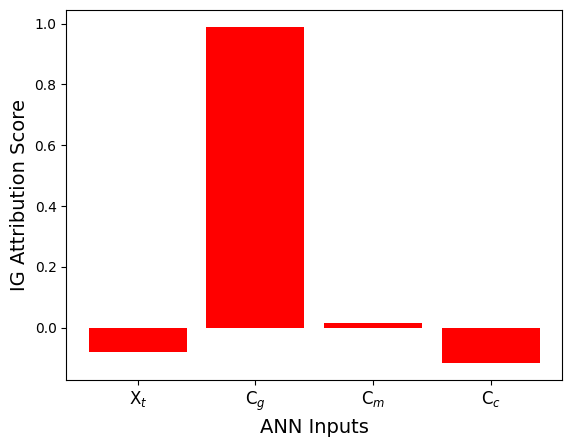

In [16]:
ig_mean = np.mean(ig_ICs[0,:,:], axis = 0)
ig_norm = ig_mean/np.linalg.norm(ig_mean)

x = 0.12*np.arange(1,5)
w = 0.1
color = ["r", "b", "y"]
plt.bar(x, ig_norm, label = "Integrated Gradeints", width = w, color = "red")
plt.ylabel("IG Attribution Score", fontsize = 14)
plt.xlabel("ANN Inputs", fontsize = 14)
plt.xticks(ticks = x, labels = ["X$_t$", "C$_g$","C$_m$","C$_c$"], fontsize = 12)
#plt.legend()
plt.savefig("ann_att.svg")
plt.show()

In [9]:
X_fl = np.vstack(X_fl)
Ig_fl = np.vstack(ig_fl)

x_temp = X_fl
a = Ig_fl

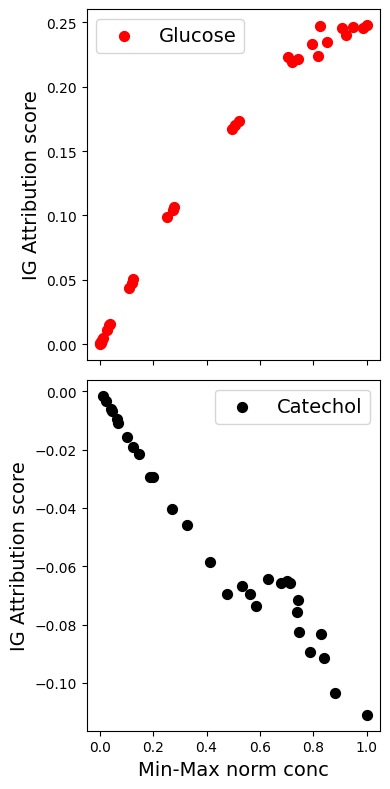

In [18]:
x_temp = X_fl
fig, axs = plt.subplots(2,1, figsize = (4,8), sharex = True)
ax = axs.ravel()
name = ["Glucose","Catechol"]
c = ["r", "k"]
a = Ig_fl
for z in range(2):
    ax[z].scatter(x_temp[0:30,2*z+1], a[0:30,2*z+1], color = c[z], s = 50, label = name[z])
    #ax[z].set_title(name[z], fontsize = 16)
    ax[z].legend(fontsize = 14)
    if z == 1:
        ax[z].set_xlabel("Min-Max norm conc", fontsize = 14)
    ax[z].set_ylabel("IG Attribution score", fontsize = 14)
plt.tight_layout()
plt.savefig("glu_cat_att.svg")